In [1]:
import numpy as np
from subprocess import getoutput
import requests
import sys
import ssl
import pandas as pd
from OpenSSL import crypto
import matplotlib.pyplot as plt
import pandas as pd
import os
from Crypto.PublicKey import RSA
from tqdm import tqdm
from functools import reduce
from collections import Counter
import csv

In [70]:
filename = 'entropy.txt'
data = open(filename).read().splitlines()


In [71]:
data = np.array(data).astype(np.int32)
x = np.arange(len(data))/2
print(data)

[3811 3811 3812 ... 3254 3260 3266]


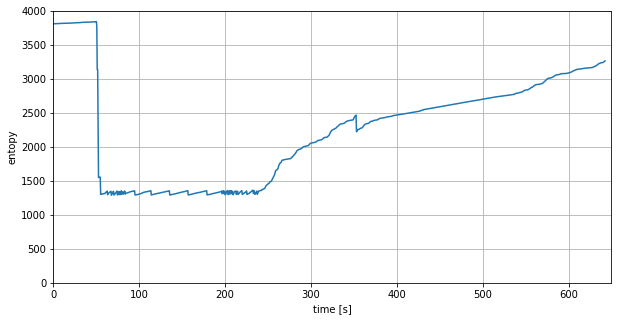

In [72]:
plt.figure(figsize=(10,5))
plt.plot(x,data)
plt.xlabel('time [s]')
plt.ylabel("entopy")
#plt.title('Wykres entropii w czasie przy generacji klucza GPG \n na sytemie Linux Mint 18')
plt.xlim(0,650)
plt.ylim(0,4000)
plt.grid()
plt.savefig('entriopia_NT.png')
plt.show()


# Scrapping data from webistes

## pobranie kluczy + czyszczenie dataframea

In [2]:
if(False):
    keys_paths = os.listdir('keys')
    keys_paths = ['keys/'+p for p in keys_paths]
    
    pd_keys = [pd.read_csv(p, index_col = 0) for p in keys_paths]
    pd_key = pd_keys[0]
    for p in pd_keys[1:]:
        pd_key = pd_key.append(p)
    
    del pd_key['Rank']
    
    pd_key = pd_key.reset_index()
    
    del pd_key['index']
    
    pd_key.loc[pd_key['Key'].notnull()]
    
    pd_key.to_csv('domeny_klucze.csv')
else:
    pd_key = pd.read_csv('domeny_klucze.csv', index_col = 0, usecols = [0, 1,3])
    
    domains_exclude = pd.read_csv('doms.csv', header = None)
    domains_exclude = domains_exclude[0].values.tolist()

## Dict = klucz : lista domen

In [3]:
if(False):
    key_page = {}
    
    for i, p in pd_key.iterrows():
        key_decode = p['Key']
        hostname = p['Domain']
        if key_decode in key_page:
            key_page[key_decode] = key_page[key_decode] + [hostname]
        else:
            key_page[key_decode] = [hostname,]
            
    del key_page[np.nan]

## Lista - klucz, liczba domen

In [4]:
if(False):
    list_keys = []
    
    for i, k in key_page.items():
        list_keys.append([i, len(k)])
        
    pd_no_keys = pd.DataFrame.from_records(list_keys)
    
    pd_no_keys.to_csv('key_count.csv')
else:
    pd_no_keys = pd.read_csv('key_count.csv', index_col = 0)

In [7]:
print('1key 1domain:', pd_no_keys.loc[ pd_no_keys.iloc[:,1] == 1, '1'].sum())
print('Alldomain:', pd_no_keys['1'].sum())

1key 1domain: 62821
Alldomain: 167421


#### plotting histograms ( before cleaning data)

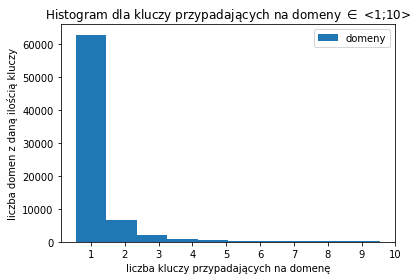

In [77]:
pd_no_keys.loc[pd_no_keys.iloc[:,1] < 11, :].plot.hist( bins = 10, align='left')
plt.legend(['domeny'])
plt.xticks(range(1,11))
plt.title(r'Histogram dla kluczy przypadających na domeny $\in$ <1;10>')
plt.xlabel('liczba kluczy przypadających na domenę')
plt.ylabel('liczba domen z daną ilością kluczy')
plt.savefig('Hist_before_1_10.png',bbox_inches='tight')

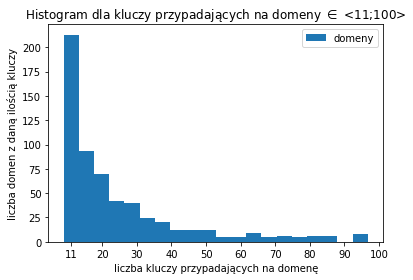

In [78]:
pd_no_keys.loc[(pd_no_keys.iloc[:,1] < 101) & (pd_no_keys.iloc[:,1] > 10), :].plot.hist(bins = 20, align='left')
x_t = [i for i in range(10,101,10)]
x_t[0] = 11
plt.xticks(x_t)
plt.title(r'Histogram dla kluczy przypadających na domeny $\in$ <11;100>')
plt.legend(['domeny'])
plt.xlabel('liczba kluczy przypadających na domenę')
plt.ylabel('liczba domen z daną ilością kluczy')
plt.savefig('Hist_before_11_100.png',bbox_inches='tight')

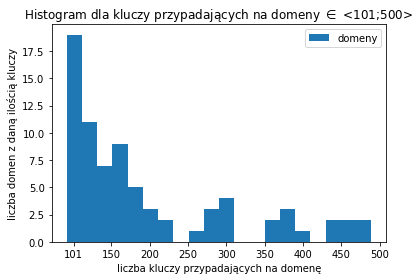

In [79]:
pd_no_keys.loc[(pd_no_keys.iloc[:,1] < 501) & (pd_no_keys.iloc[:,1] > 100), :].plot.hist(bins = 20, align='left')
x_t = [i for i in range(100,501,50)]
x_t[0] = 101
plt.xticks(x_t)
plt.title(r'Histogram dla kluczy przypadających na domeny $\in$ <101;500>')
plt.legend(['domeny'])
plt.xlabel('liczba kluczy przypadających na domenę')
plt.ylabel('liczba domen z daną ilością kluczy')
plt.savefig('Hist_before_101_500.png',bbox_inches='tight')

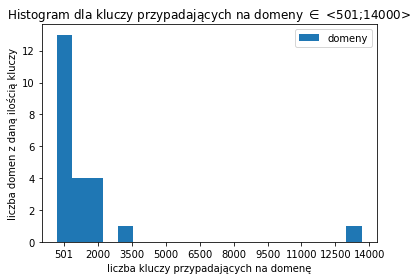

In [80]:
pd_no_keys.loc[(pd_no_keys.iloc[:,1] > 500), :].plot.hist(bins = 20, align='left')
x_t = [i for i in range(500,14501,1500)]
x_t[0] = 501
plt.xticks(x_t)
plt.title(r'Histogram dla kluczy przypadających na domeny $\in$ <501;14000>')
plt.legend(['domeny'])
plt.xlabel('liczba kluczy przypadających na domenę')
plt.ylabel('liczba domen z daną ilością kluczy')
plt.savefig('Hist_before_501_14000.png',bbox_inches='tight')

#### plotting keys

In [81]:
if False:
    keys_list = pd_no_keys.loc[:,1].values.tolist()
    
    keys_list.sort()
    keys_list = np.array(keys_list)
    
    plt.figure(figsize=(10,5))
    plt.plot(keys_list[keys_list>1], 'o')

#### TO DO : for each key find main domain and reduce number of keys to this one domain

In [82]:
key_13000 = pd_no_keys.loc[ (pd_no_keys.iloc[:,1] > 13000),'0'].values.tolist()[0]
key_13000

"b'-----BEGIN PUBLIC KEY-----\\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzWJP5cMThJgMBeTvRKKl\\n7N6ZcZAbKDVAtNBNnRhIgSitXxCzKtt9rp2RHkLn76oZjdNO25EPp+QgMiWU/rkk\\nB00Y18Oahw5fi8s+K9dRv6i+gSOiv2jlIeW/S0hOswUUDH0JXFkEPKILzpl5ML7w\\ndp5kt93vHxa7HswOtAxEz2WtxMdezm/3CgO3sls20wl3W03iI+kCt7HyvhGy2aRP\\nLhJfeABpQr0Uku3q6mtomy2cgFawekN/X/aH8KknX799MPcuWutM2q88mtUEBsuZ\\nmy2nsjK9J7/yhhCRDzOV/yY8c5+l/u/rWuwwkZ2lgzGp4xBBfhXdr6+m9kmwWCUm\\n9QIDAQAB\\n-----END PUBLIC KEY-----\\n'"

In [83]:
pd_key.loc[pd_key.loc[:,'Key'] == key_13000, 'Domain'].values.tolist()

['lokalzeitjunkie.blogspot.de',
 'mrinfokrieg.blogspot.de',
 'bulledop-bouquine.blogspot.fr',
 'humeursmondialisees.blogspot.fr',
 'kurislaw.blogspot.co.il',
 'trends.google.com.br',
 'atelierrueverte.blogspot.fr',
 'livresrecommende.blogspot.co.uk',
 'handwerkauspapier.blogspot.de',
 'roseetvert.blogspot.fr',
 'schrijfgelukjes.blogspot.nl',
 'flowerdesignstannes.blogspot.co.uk',
 'jufmarlieke.blogspot.nl',
 'ohjunge.blogspot.de',
 'koduhaldjas.blogspot.fr',
 '9273741.fls.doubleclick.net',
 '9273754.fls.doubleclick.net',
 '9273787.fls.doubleclick.net',
 '9274007.fls.doubleclick.net',
 '9274015.fls.doubleclick.net',
 '9274025.fls.doubleclick.net',
 '9274037.fls.doubleclick.net',
 '9274196.fls.doubleclick.net',
 '9274211.fls.doubleclick.net',
 '9274247.fls.doubleclick.net',
 '9274621.fls.doubleclick.net',
 '9274912.fls.doubleclick.net',
 '9275232.fls.doubleclick.net',
 '9275529.fls.doubleclick.net',
 '9275814.fls.doubleclick.net',
 '9275835.fls.doubleclick.net',
 '9276405.fls.doubleclick

In [84]:
#mapping functions to make domains the same
#https://stackoverflow.com/questions/42742711/pandas-select-slice-then-map-function-over-columns
pd_key['Domain'] = pd_key['Domain'].map(lambda x: "doubleclick.net" if "doubleclick.net" in x else x)
pd_key['Domain'] = pd_key['Domain'].map(lambda x: "blogspot.com" if "blogspot." in x else x)
pd_key['Domain'] = pd_key['Domain'].map(lambda x: "googleblog.com" if "googleblog." in x else x)

In [85]:
pd_key.loc[ pd_key.loc[:,'Domain'] == 'googleapis.com', :]

,Domain,Key
58828,googleapis.com,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...


In [86]:
pd_key.drop_duplicates(inplace=True) 

In [87]:
pd_key.loc[ pd_key.loc[:,'Domain'] == "googleusercontent.com", :]

,Domain,Key


### Ratio

In [89]:
print('domens:', np.sum(pd_no_keys['1'].values))
print('share key:', np.sum(pd_no_keys['1'].values[pd_no_keys['1'].values > 1]))
print('ratio:', np.sum(pd_no_keys['1'].values[pd_no_keys['1'].values > 1])/np.sum(pd_no_keys['1'].values))

domens: 167421
share key: 104600
ratio: 0.624772280657743


In [22]:
pd_no_keys.loc[pd_no_keys.loc[:,'1'] > 2,:].sort_values(by=['1'],ascending=False)

,0,1
304,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,13997
26,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3608
7,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,2255
22,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,2155
27,b'-----BEGIN PUBLIC KEY-----\nMFkwEwYHKoZIzj0C...,2129
...,...,...
17325,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3
17324,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3
17292,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...,3
3657,b'-----BEGIN PUBLIC KEY-----\nMIICIjANBgkqhkiG...,3


## Duplikaty

In [17]:
# unique keys 
keys_gr1 = pd_no_keys.loc[pd_no_keys.loc[:,'1'] > 1, '0']
keys_gr1 = set(keys_gr1.values.tolist())

In [22]:
# function to get the last which is not co com eu etc
def domain(list_i):
    list_split = list_i.split('.')
    if len(list_split) > 2:
        list_tmp = list_split[:-1]
    else:
        list_tmp = list_split
        
    if type(list_tmp) == list:
        list_tmp.reverse()
        not_find = True
        j = 0
        xi = 'com'
        while (xi in domains_exclude):
            try: 
                xi = list_tmp[j]
            except:
                xi = list_i
                break
            j += 1
    else: 
        xi = list_tmp
    
    return xi

In [25]:
if True:
    pd_key_celan = pd_key.copy()
    
    for k in tqdm(keys_gr1):
        list_t = pd_key.loc[pd_key.loc[:,'Key'] == k, 'Domain'].values.tolist()
        # split on dot - and get rid of last part com/uk/pl etc
        # and make dictionary : domain - pages 
        domains_pages = {}
        for p in list_t:
            d = domain(p)
            if d in domains_pages:
                domains_pages[d] = domains_pages[d] + [p]
            else:
                domains_pages[d] = [p,]
        # change pages for the first from list 
        for d, p in domains_pages.items():
            #pd_key_celan.loc[p, 'Domain'] =  d
            pd_key_celan.loc[(pd_key_celan['Key'] == k) & (pd_key_celan['Domain'].isin(p)), 'Domain'] = d
        
    pd_key_celan.drop_duplicates(inplace=True)
    pd_key_celan = pd_key_celan.loc[ pd_key_celan['Key'].notnull(), :]
    
    pd_key_celan.to_csv('domeny_klucze_clean_I.csv')
else:
    pd_key_celan = pd.read_csv('domeny_klucze_clean_I.csv', index_col = 0)

100%|██████████| 11361/11361 [52:00<00:00,  3.64it/s]  


In [19]:
k = "b'-----BEGIN PUBLIC KEY-----\\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzWJP5cMThJgMBeTvRKKl\\n7N6ZcZAbKDVAtNBNnRhIgSitXxCzKtt9rp2RHkLn76oZjdNO25EPp+QgMiWU/rkk\\nB00Y18Oahw5fi8s+K9dRv6i+gSOiv2jlIeW/S0hOswUUDH0JXFkEPKILzpl5ML7w\\ndp5kt93vHxa7HswOtAxEz2WtxMdezm/3CgO3sls20wl3W03iI+kCt7HyvhGy2aRP\\nLhJfeABpQr0Uku3q6mtomy2cgFawekN/X/aH8KknX799MPcuWutM2q88mtUEBsuZ\\nmy2nsjK9J7/yhhCRDzOV/yY8c5+l/u/rWuwwkZ2lgzGp4xBBfhXdr6+m9kmwWCUm\\n9QIDAQAB\\n-----END PUBLIC KEY-----\\n'"
pd_key.loc[pd_key['Key'] == k, : ]

,Domain,Key
646,lokalzeitjunkie.blogspot.de,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
647,mrinfokrieg.blogspot.de,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
816,bulledop-bouquine.blogspot.fr,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
817,humeursmondialisees.blogspot.fr,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
898,kurislaw.blogspot.co.il,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
...,...,...
233770,earthsjourneytolife.blogspot.com,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233771,frappedoupoli.blogspot.com,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233772,galileowaswrong.blogspot.com,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233773,mortgagemovies.blogspot.com,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...


In [ ]:
pd_key_celan.loc[(pd_key_celan['Key'] == k),:]

In [23]:
pd_key_celan = pd_key.copy()
list_t = pd_key.loc[pd_key.loc[:,'Key'] == k, 'Domain'].values.tolist()
# split on dot - and get rid of last part com/uk/pl etc
# and make dictionary : domain - pages 
for p in tqdm(list_t):
    d = domain(p)
    pd_key_celan.loc[(pd_key_celan['Key'] == k) & (pd_key_celan['Domain'] == p), 'Domain'] = d

100%|██████████| 13997/13997 [09:34<00:00, 24.36it/s]


In [24]:
pd_key_celan.loc[(pd_key_celan['Key'] == k),:]

,Domain,Key
646,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
647,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
816,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
817,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
898,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
...,...,...
233770,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233771,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233772,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
233773,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...


### Take list of domains for given key

In [7]:
list_1 = pd_key.loc[pd_key.loc[:,'Key'] == keys_gr1.values[0], 'Domain'].values.tolist()
list_1

['mattpresti.com',
 'saabkyle04.com',
 'ystuds.com',
 'apacouc.org',
 'juliacannon.com',
 'jimmydehartsr.com',
 'kadalystbeatz.com',
 'keithong.com',
 'keolafit.com',
 'kevingerdes.com',
 'ladygardenhk.com',
 'lawgivermusic.com',
 'lifeofanactress.com',
 'lownotesgarage.com',
 'uncyclopedia.org',
 'afterthecut.com',
 'heavenvisit.net',
 'motoramaevents.com',
 'zarinas.com',
 'ourlgbtstories.com',
 'papersailor.com',
 'planetzaxxon.com',
 'poolaholic.com',
 'realjobsb.com',
 'richardjamesahern.com',
 'speechandlanguagesongs.com',
 'noreenskitchen.com',
 'firemountainoutdoors.com',
 'fishlikeus.com',
 'flybyvideopros.com',
 'apriori.rocks',
 'billvanderbush.com',
 'coachrickthemittologist.com',
 'colouredbeautiful.com',
 'dirtydirtydishes.com',
 'flatscreenclean.com',
 'fretboard-toolbox.com',
 'heartofartgalleryla.com',
 'store.teamlight.com',
 'wish4fish.com',
 'sceniccityfishing.com',
 'mhubbardmusic.com',
 'shop.millenniumdancecomplex.com',
 'missnadiagold.com',
 'nationsquid.com',
 

### Common prefix

In [8]:
os.path.commonprefix(list_1)

''

### Common part of domain

In [9]:
test_list = [list_i.split('.')[:-1] for list_i in list_1]
test_list

[['mattpresti'],
 ['saabkyle04'],
 ['ystuds'],
 ['apacouc'],
 ['juliacannon'],
 ['jimmydehartsr'],
 ['kadalystbeatz'],
 ['keithong'],
 ['keolafit'],
 ['kevingerdes'],
 ['ladygardenhk'],
 ['lawgivermusic'],
 ['lifeofanactress'],
 ['lownotesgarage'],
 ['uncyclopedia'],
 ['afterthecut'],
 ['heavenvisit'],
 ['motoramaevents'],
 ['zarinas'],
 ['ourlgbtstories'],
 ['papersailor'],
 ['planetzaxxon'],
 ['poolaholic'],
 ['realjobsb'],
 ['richardjamesahern'],
 ['speechandlanguagesongs'],
 ['noreenskitchen'],
 ['firemountainoutdoors'],
 ['fishlikeus'],
 ['flybyvideopros'],
 ['apriori'],
 ['billvanderbush'],
 ['coachrickthemittologist'],
 ['colouredbeautiful'],
 ['dirtydirtydishes'],
 ['flatscreenclean'],
 ['fretboard-toolbox'],
 ['heartofartgalleryla'],
 ['store', 'teamlight'],
 ['wish4fish'],
 ['sceniccityfishing'],
 ['mhubbardmusic'],
 ['shop', 'millenniumdancecomplex'],
 ['missnadiagold'],
 ['nationsquid'],
 ['nickalligood'],
 ['ontariostreetoutlaws'],
 ['patrickarbour'],
 ['renireni'],
 ['the

In [49]:
# function to get the last which is not co com eu etc
def domain(list_i):
    list_tmp = list_i.split('.')[:-1]
    if type(list_tmp) == list:
        list_tmp.reverse()
        not_find = True
        j = 0
        xi = 'com'
        while (xi in ('com', 'co', 'org', 'net', 'edu')):
            xi = list_tmp[j]
            j += 1
    else: 
        xi = list_tmp
    return xi
# list of domains conneted with diven public key
k = "b'-----BEGIN PUBLIC KEY-----\\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzWJP5cMThJgMBeTvRKKl\\n7N6ZcZAbKDVAtNBNnRhIgSitXxCzKtt9rp2RHkLn76oZjdNO25EPp+QgMiWU/rkk\\nB00Y18Oahw5fi8s+K9dRv6i+gSOiv2jlIeW/S0hOswUUDH0JXFkEPKILzpl5ML7w\\ndp5kt93vHxa7HswOtAxEz2WtxMdezm/3CgO3sls20wl3W03iI+kCt7HyvhGy2aRP\\nLhJfeABpQr0Uku3q6mtomy2cgFawekN/X/aH8KknX799MPcuWutM2q88mtUEBsuZ\\nmy2nsjK9J7/yhhCRDzOV/yY8c5+l/u/rWuwwkZ2lgzGp4xBBfhXdr6+m9kmwWCUm\\n9QIDAQAB\\n-----END PUBLIC KEY-----\\n'"
list_t = pd_key.loc[pd_key.loc[:,'Key'] == k, 'Domain'].values.tolist()
# split on dot - and get rid of last part com/uk/pl etc
# and make dictionary : domain - pages 
domains_pages = {}
for p in list_t:
    d = domain(p)
    if d in domains_pages:
        domains_pages[d] = domains_pages[d] + [p]
    else:
        domains_pages[d] = [p,]
# change pages for the first from list 
for d, p in domains_pages.items():
    pd_key.loc[(pd_key['Key'] == k) & (pd_key['Domain'].isin(p)), 'Domain'] = d

pd_key.drop_duplicates(inplace=True) 
pd_key.loc[(pd_key['Key'] == k), :]

,Domain,Key
646,blogspot,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
2238,google,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
3000,doubleclick,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
5675,ytimg,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
7127,googlesyndication,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
...,...,...
220732,solveforx,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
223376,emergent,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
225167,quickoffice,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...
229258,cloudconnectcommunity,b'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG...


In [36]:
res = list(reduce(lambda i, j: i & j, (set(x) for x in test_list))) 
res

[]

# Key to number
#### wybierz klucz z ramki danych

In [39]:
key_str = pd_no_keys.loc[pd_no_keys.loc[:,1] > 1,:].sort_values(by=[1],ascending=False).iloc[0,0]

#### oczyść z \\\n oraz początku i końca

In [48]:
key_clean = key_str[30:-29].replace('\\n', '')
key_clean

'MIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzWJP5cMThJgMBeTvRKKl7N6ZcZAbKDVAtNBNnRhIgSitXxCzKtt9rp2RHkLn76oZjdNO25EPp+QgMiWU/rkkB00Y18Oahw5fi8s+K9dRv6i+gSOiv2jlIeW/S0hOswUUDH0JXFkEPKILzpl5ML7wdp5kt93vHxa7HswOtAxEz2WtxMdezm/3CgO3sls20wl3W03iI+kCt7HyvhGy2aRPLhJfeABpQr0Uku3q6mtomy2cgFawekN/X/aH8KknX799MPcuWutM2q88mtUEBsuZmy2nsjK9J7/yhhCRDzOV/yY8c5+l/u/rWuwwkZ2lgzGp4xBBfhXdr6+m9kmwWCUm9QIDAQAB'

#### zamień na liczbę

In [49]:
key_int = int.from_bytes(key_clean.encode(), 'little')
key_int

27736142053001972894141168940794628257122595916689500327337814341233702579571191726171192003997939169360692208972473464481406697865724011100281443278195278731581691888597354870140246748527444181992252960189151142429554895594863583933923480159126397675192644829119313833703381348968107358436189284486758101278432697304788189716200964589051457558010627706789891951021560856034917805031622495121390702751622947874597999855708672897851711176185905178728389036613779517873556148898466029667317655253909482911745643898582334852578745527682659988105625551105956650520112190774383411319292036989510245130812474077825149865366508826306186444989755628705474943049498460670576842747728621377488734773120353865848580006325434517215958345375320127948921509092572086071871468998600692328490902561812395023297361667096083466166049262940079979675425955889450823899265465043743768226651703902405844287893956335783700461288503339388260968956568468069414657935693